<h1>SPY TLT Dynamic Allocation</h1>

<p>Last updated 04/09/2020</p>
<p>Since we are experiencing a huge drawdown in the SP 500 I thought it would be a good opportunity to play around with a strategy that does well in market drawdowns (ie. SPY-TLT Allocation). Here instead of SPY I will be using IVV, which is basically the same. I will experiment with SPYTLT Allocations that are daily rebalancin & fully invested.</p>

In [1]:
#libraries I will be using
import json
import smtplib

import numpy as np
import pandas as pd
import quantstats as qs
import yahoofinancials as yf

from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import exp_cov
from pypfopt.expected_returns import prices_from_returns

from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.utils import COMMASPACE, formatdate
from datetime import datetime, timedelta, date

from yahoo_fin import stock_info as si

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

In [2]:
#some functions I might need
def daterange(start_date, end_date):
    ''' 
    daterange(date(2005, 12, 31), date(2020, 3, 25))
    creates range between 2 dates given
    '''
    for n in range(int ((end_date - start_date).days)):
        yield pd.to_datetime(start_date + timedelta(n))

def get_hist_prices(symbol, start_date, end_date, time_interval):
    '''
    get_historical_prices('TLT', '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
    uses yahoo financials to download stock prices monthly, weekly or daily
    '''
    obj = yf.YahooFinancials(symbol)
    data = obj.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
    df = pd.DataFrame(data[symbol]['prices'])
    df = df.rename(columns={'formatted_date':'Date'})
    df = df.set_index(df['Date'], drop=True)
    
    try:
        divs = pd.DataFrame(data[symbol]['eventsData']['dividends']).T
        divs = divs.rename(columns={'formatted_date':'Date','amount':'dividend'})
        divs = divs.set_index(divs['Date'],drop=True)
        df = df.merge(divs['dividend'],left_index=True,right_index=True,how='outer')
        df['dividend'] = df['dividend'].fillna(0)
        df['log_div_return']=np.log(df['adjclose']/(df['adjclose']-df['dividend']))
        df['div_return'] = (df['dividend'])/df['adjclose'].shift(1)
    except:
        pass
    
    try:
        df['log_total_return']=np.log(df['adjclose']/df['adjclose'].shift(1))  
        df['log_price_return']=np.log(df['close']/df['close'].shift(1))
        df['total_return'] = (df['adjclose']-df['adjclose'].shift(1))/df['adjclose'].shift(1)
        df['price_return']= (df['close']-df['close'].shift(1))/df['close'].shift(1)
        df['1M_Vol'] = df['log_price_return'].rolling(21).std() * np.sqrt(251)
        df['3M_Vol'] = df['log_price_return'].rolling(63).std() * np.sqrt(251)
        df['1M_Return'] = df['log_total_return'].rolling(21).sum()
        df['3M_Return'] = df['log_total_return'].rolling(63).sum()
    except:
        pass

    df = df.add_suffix('_'+symbol) 
    return df

def get_list_hist_price(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['close_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_price_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['price_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_total_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['log_total_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

In [3]:
#Getting prices
ivv_tlt_prices = get_list_hist_price(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_prices = ivv_tlt_prices.dropna()
ivv_tlt_prices = (ivv_tlt_prices / ivv_tlt_prices.iloc[0] -1) 

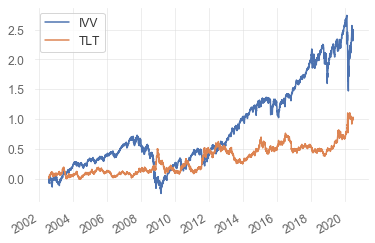

In [4]:
#plotting prices
ivv_tlt_prices.plot()

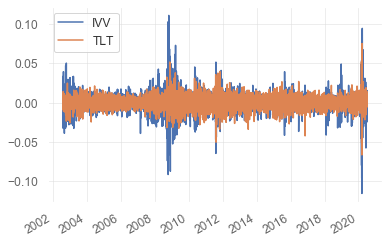

In [5]:
ivv_tlt_price_returns = get_list_hist_price_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_price_returns = ivv_tlt_price_returns.dropna()
ivv_tlt_price_returns.plot()

<p>As far as price returns it seems like SPY is a better investment from a return perspective</p>

In [6]:
ivv_tlt_total_returns = get_list_hist_total_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_total_returns = ivv_tlt_total_returns.add_suffix('_Return')

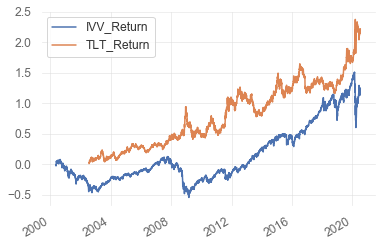

In [7]:
((ivv_tlt_total_returns[['IVV_Return','TLT_Return']] + 1).cumprod(skipna=True)-1).plot()

<p>From a total return perspective it seems like TLT is also a good investment</p>

<h2>Minimum Variance Portfolio with a Exp. Covariance Matrix Span = 13</h2>
<p>Creating a Minimum Variance Portfolio with an Exp. Covasriance Matrix (with Span = 13). I use a span of 13 because it other projects it has seems to produce a pretty good covariance matrix for daily rebalacign. I am aware that a SPan of 13 is really short and that a span minumum 30 is recommended. This is just to test our idea</p>

In [8]:
dates = daterange(date(2003, 12, 31), date(2020, 4, 8))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
    cov = exp_cov(prices,span=13,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, 1)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']

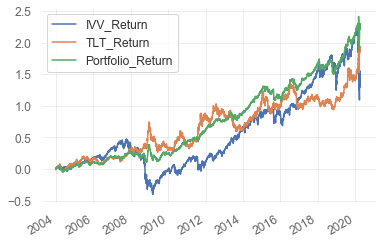

In [9]:
((weights_total_returns[['IVV_Return','TLT_Return','Portfolio_Return']] + 1).cumprod(skipna=False)-1).plot()

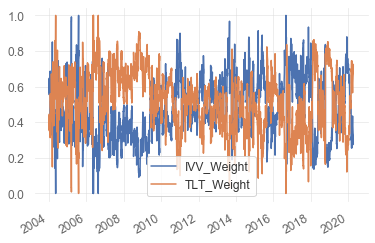

In [10]:
weights_total_returns[['IVV_Weight','TLT_Weight']].plot()

<p>It seems that our portfolio performs inline with SPY and TLT with much less volatility. It also seems that the allocation between SPY and TLT changes very drastically from day to day but generally follows a trend; for example 2008 and 2019 there is clearing a higher allocation to bonds (TLT).<p\>

<p>Now lets look at some expost stats vs. SPY</p>

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          228.98%     154.88%
CAGR%                      7.59%       5.92%
Sharpe                     0.92        0.4
Sortino                    1.29        0.54
Max Drawdown               -19.24%     -59.34%
Longest DD Days            630         2043
Volatility (ann.)          8.34%       19.09%
R^2                        0.17        0.17
Calmar                     0.39        0.1
Skew                       -0.63       -0.54
Kurtosis                   8.95        14.39

Expected Daily %           0.03%       0.02%
Expected Monthly %         0.61%       0.48%
Expected Yearly %          7.26%       5.66%
Kelly Criterion            6.37%       2.24%
Risk of Ruin               0.0%    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.244248,-18.391655
2,2020-03-09,2020-03-18,2020-04-08,30,-15.669689,-14.091227
3,2007-12-04,2008-10-31,2008-12-08,370,-13.751267,-13.277358
4,2015-02-03,2016-01-11,2016-06-03,486,-9.997805,-9.457622
5,2004-03-08,2004-05-13,2004-12-15,282,-9.844659,-9.350385


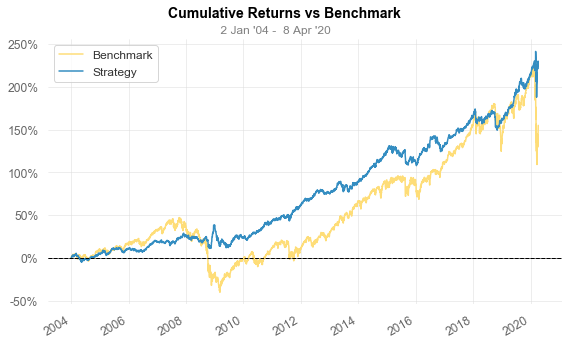

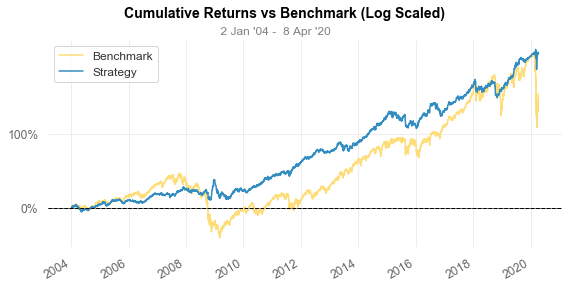

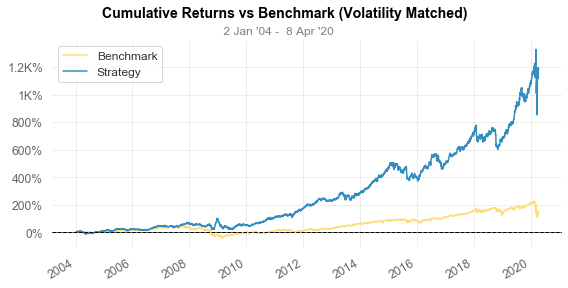

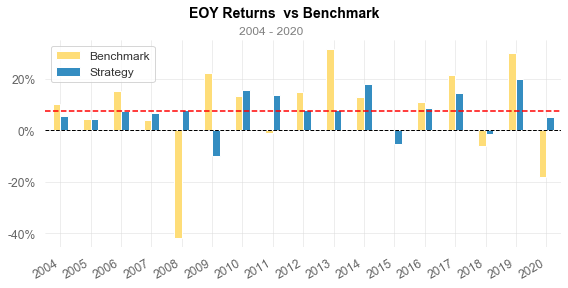

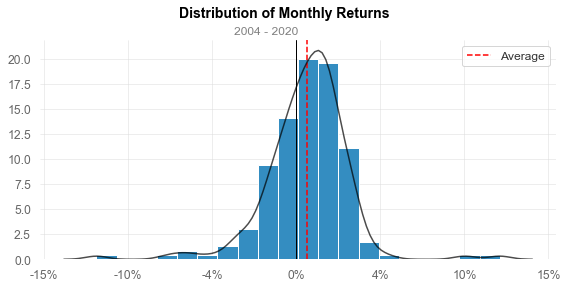

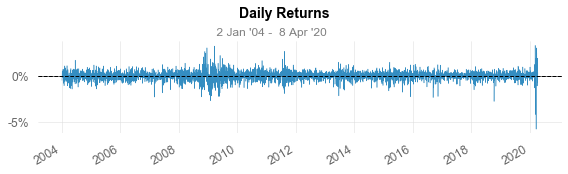

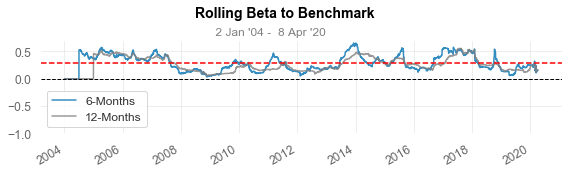

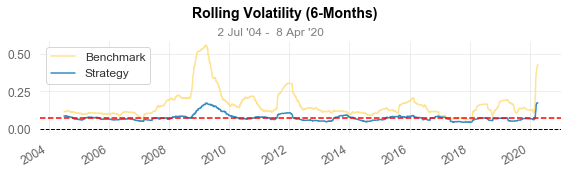

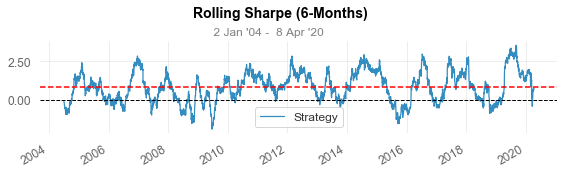

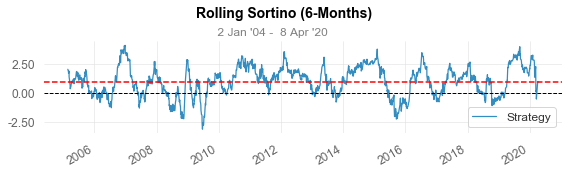

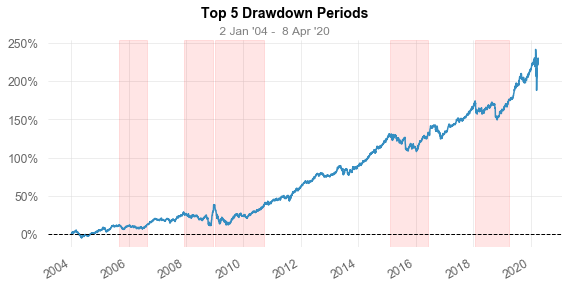

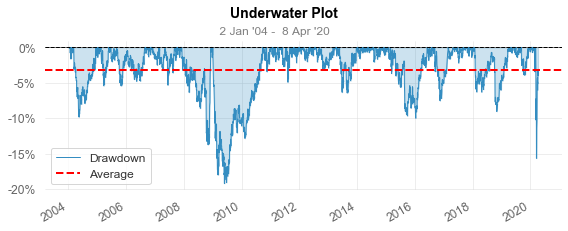

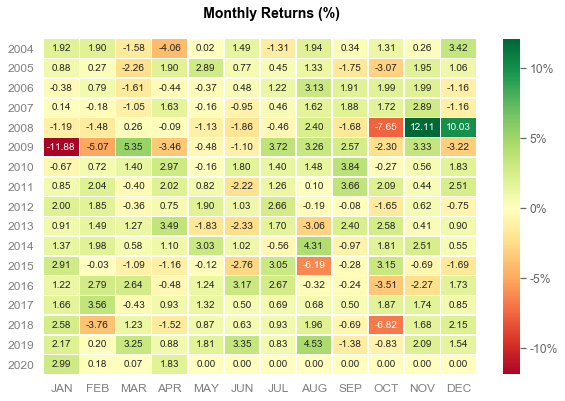

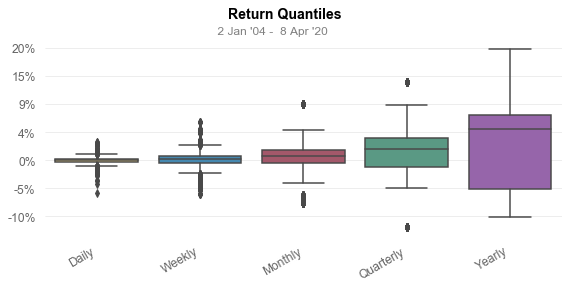

In [11]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['IVV_Return'])

<p>It looks like the portfolio we created performs as expected. Some stats that I would like to point out; It has a return of 227.68%, volatility of 8.34%  and beta of 0.18. Perhaps the most interestinf observation (to me at least) is the returns by calender year. This shows that for most years our portfolio does not out perform SPY but where our portfolio really shines is in 2008 and YTD 2020. What is also interesting is that it underperforms SPY in 2009 and 2013.</p>

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          228.98%     188.0%
CAGR%                      7.59%       6.71%
Sharpe                     0.92        0.53
Sortino                    1.29        0.77
Max Drawdown               -19.24%     -27.37%
Longest DD Days            630         1116
Volatility (ann.)          8.34%       14.01%
R^2                        0.28        0.28
Calmar                     0.39        0.25
Skew                       -0.63       0.01
Kurtosis                   8.95        5.07

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.61%       0.54%
Expected Yearly %          7.26%       6.42%
Kelly Criterion            9.07%       -0.32%
Risk of Ruin               0.0%    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.244248,-18.391655
2,2020-03-09,2020-03-18,2020-04-08,30,-15.669689,-14.091227
3,2007-12-04,2008-10-31,2008-12-08,370,-13.751267,-13.277358
4,2015-02-03,2016-01-11,2016-06-03,486,-9.997805,-9.457622
5,2004-03-08,2004-05-13,2004-12-15,282,-9.844659,-9.350385


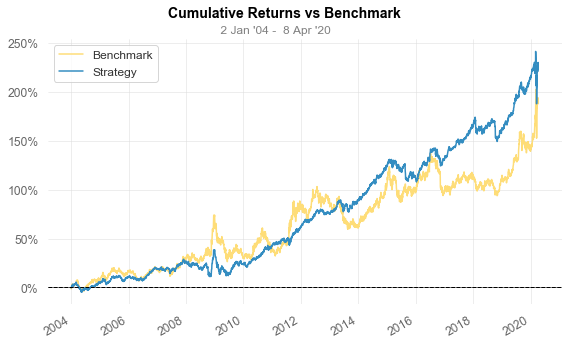

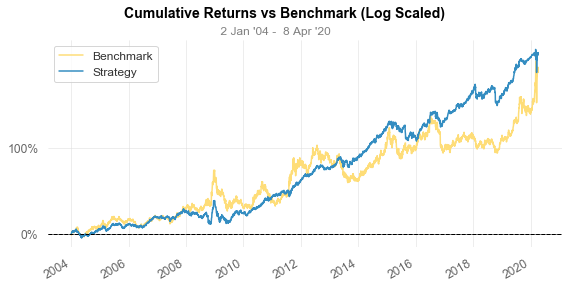

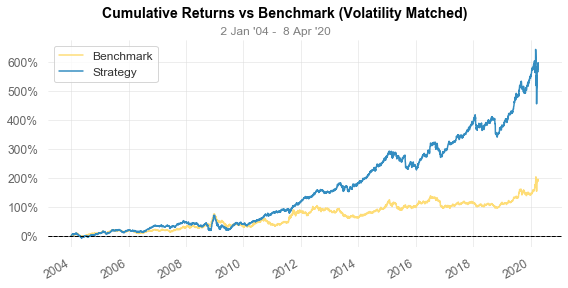

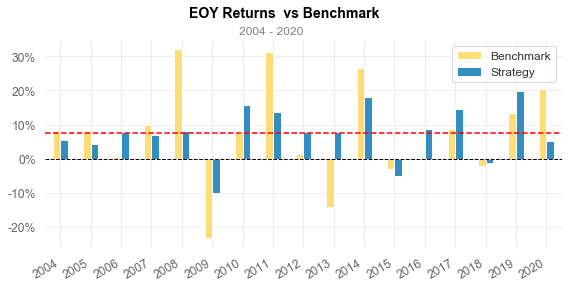

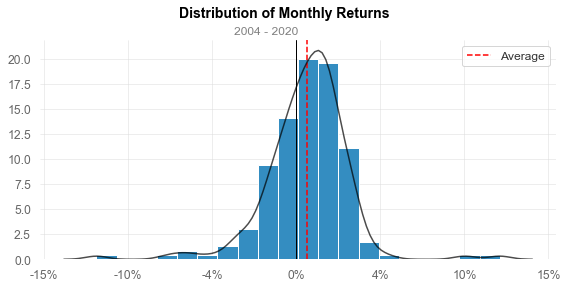

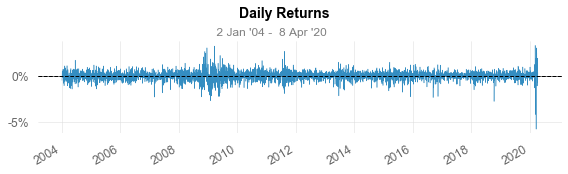

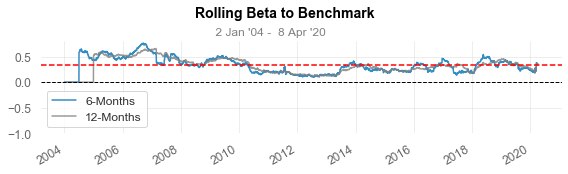

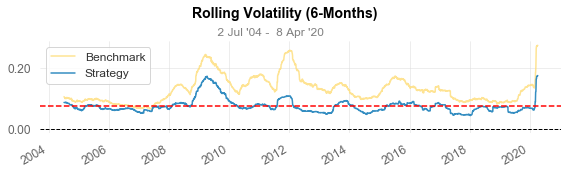

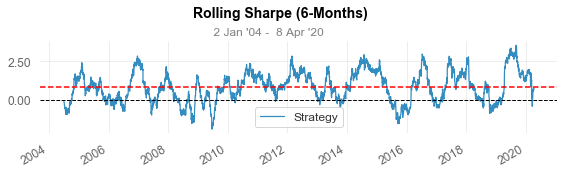

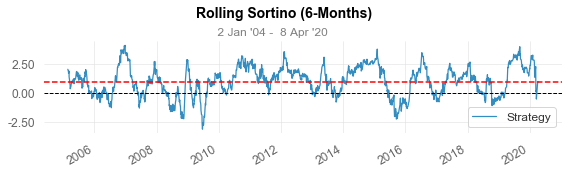

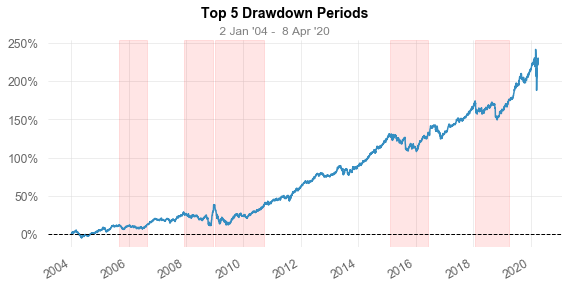

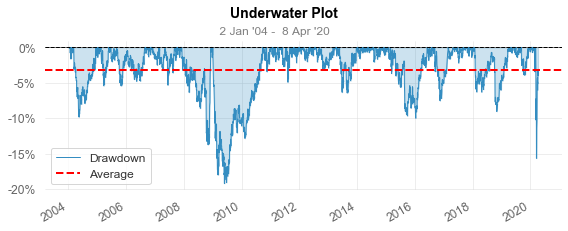

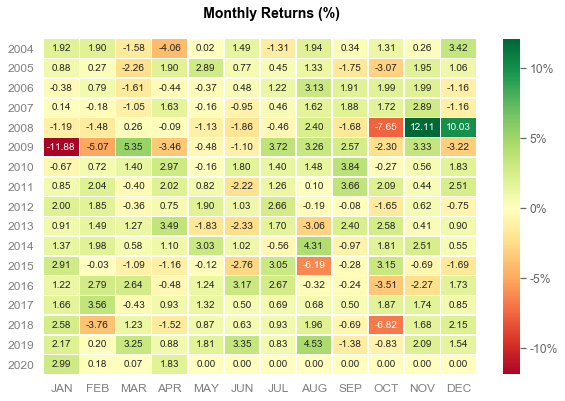

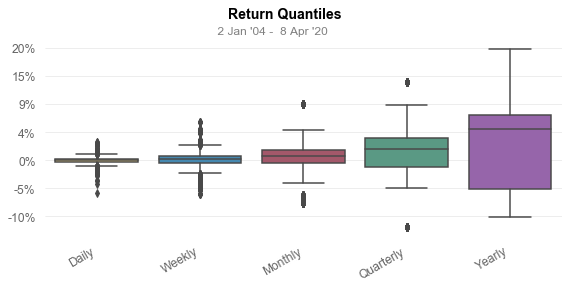

In [12]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['TLT_Return'])

<p>Not as interesting as vs. SPY</p>

<h2>Maximum Sharpe Portfolio using Historical Returns and Exponential Covariance MAtrix</h2>
<p>Here I am experimenting with using maximum sharpe portfolio using historical returns as expected returns and exponential covariance matrix with span = 13. The major problem here is that at the beginning of our analysis there is not data and therefor the expected return is more likely to change with daily changes, this will probably effect our allocations</p>

In [13]:
dates = daterange(date(2003, 12, 31), date(2020, 4, 8))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
    total_returns = ivv_tlt_total_returns[ivv_tlt_total_returns.index<d]
    ivv_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['IVV_Return'].dropna()))
    tlt_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['TLT_Return'].dropna()))
    cov = exp_cov(prices,span=13,frequency=252)
    ef = EfficientFrontier(expected_returns=[ivv_return,tlt_return],cov_matrix=cov, weight_bounds=(0, 1)) 
    day_weights = ef.max_sharpe(risk_free_rate=0.02)
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']

C:\ProgramData\Anaconda3\lib\site-packages\pypfopt\expected_returns.py:67: RuntimeWarning:

prices are not in a dataframe



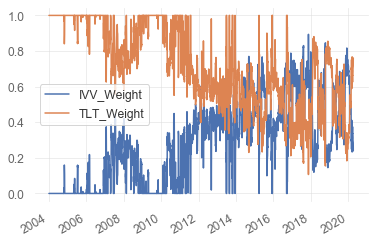

In [14]:
weights_total_returns[['IVV_Weight','TLT_Weight']].plot()

<p>The allocation between SPY and TLT doesn't seem as dynamic as I would've liked. Let's see what our stats look like.</p>

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          190.37%     154.88%
CAGR%                      6.77%       5.92%
Sharpe                     0.7         0.4
Sortino                    0.98        0.54
Max Drawdown               -26.29%     -59.34%
Longest DD Days            1041        2043
Volatility (ann.)          10.1%       19.09%
R^2                        0.0         0.0
Calmar                     0.26        0.1
Skew                       -0.46       -0.54
Kurtosis                   5.93        14.39

Expected Daily %           0.03%       0.02%
Expected Monthly %         0.55%       0.48%
Expected Yearly %          6.47%       5.66%
Kelly Criterion            4.68%       3.78%
Risk of Ruin               0.0%     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-06-10,2011-11-07,1041,-26.290426,-24.377316
2,2020-03-09,2020-03-18,2020-04-08,30,-15.779357,-14.169407
3,2008-09-17,2008-10-31,2008-11-28,72,-11.531106,-11.336576
4,2013-05-03,2013-08-21,2014-05-01,363,-11.394242,-10.408385
5,2004-03-17,2004-05-13,2004-09-22,189,-10.939996,-10.420040


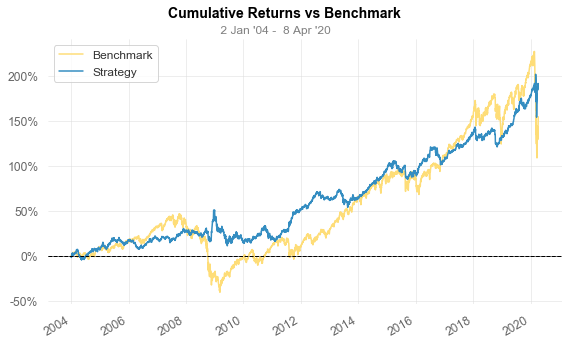

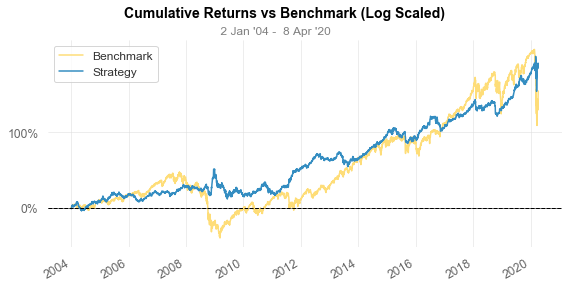

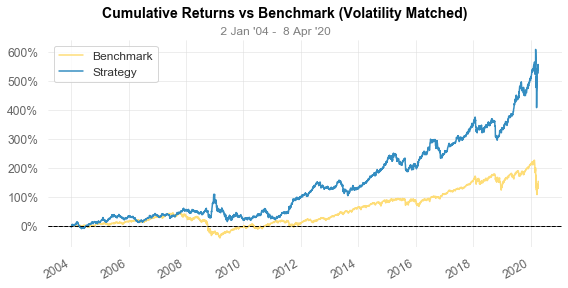

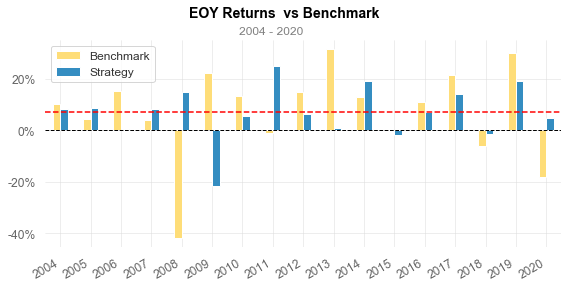

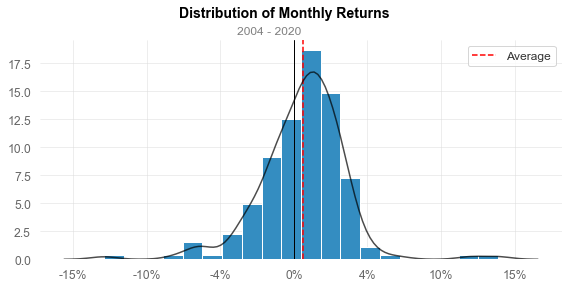

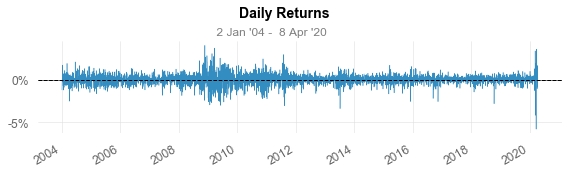

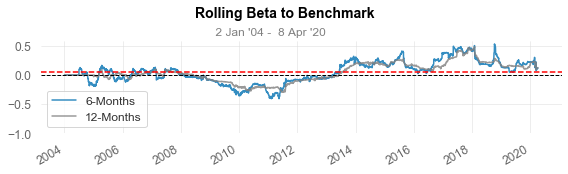

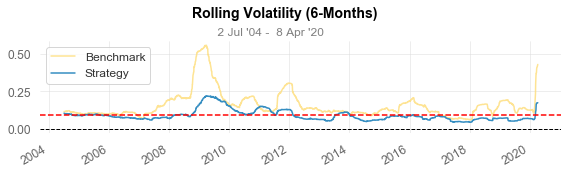

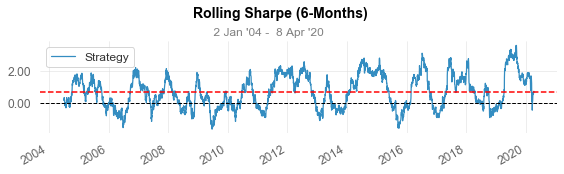

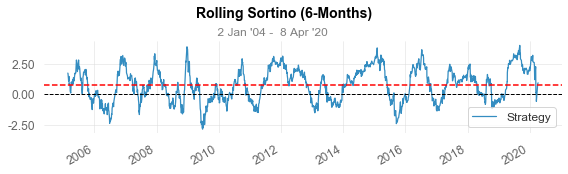

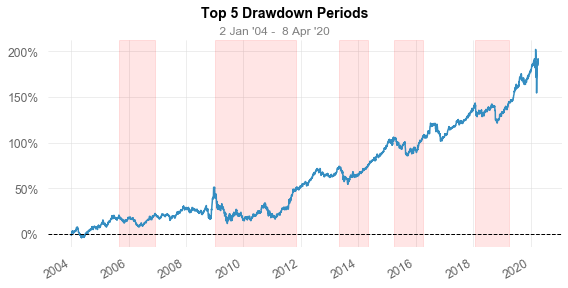

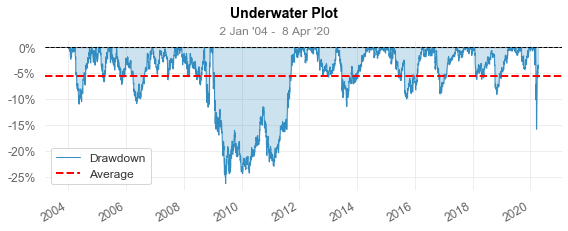

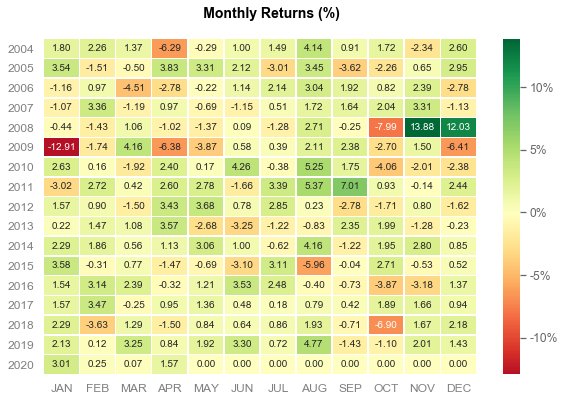

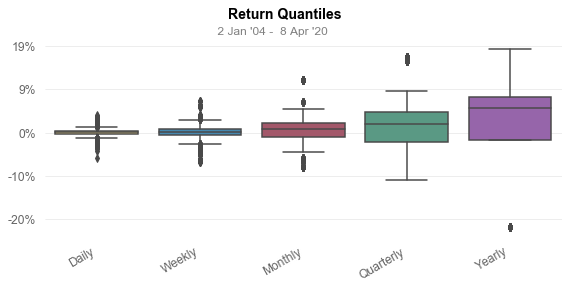

In [15]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['IVV_Return'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          190.37%     188.0%
CAGR%                      6.77%       6.71%
Sharpe                     0.7         0.53
Sortino                    0.98        0.77
Max Drawdown               -26.29%     -27.37%
Longest DD Days            1041        1116
Volatility (ann.)          10.1%       14.01%
R^2                        0.63        0.63
Calmar                     0.26        0.25
Skew                       -0.46       0.01
Kurtosis                   5.93        5.07

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.55%       0.54%
Expected Yearly %          6.47%       6.42%
Kelly Criterion            7.03%       1.8%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-06-10,2011-11-07,1041,-26.290426,-24.377316
2,2020-03-09,2020-03-18,2020-04-08,30,-15.779357,-14.169407
3,2008-09-17,2008-10-31,2008-11-28,72,-11.531106,-11.336576
4,2013-05-03,2013-08-21,2014-05-01,363,-11.394242,-10.408385
5,2004-03-17,2004-05-13,2004-09-22,189,-10.939996,-10.420040


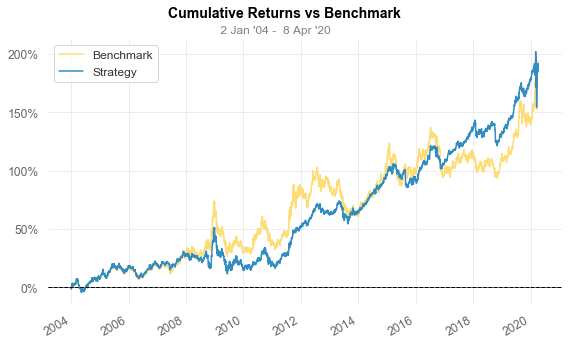

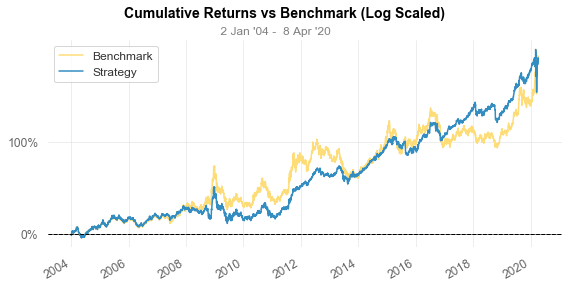

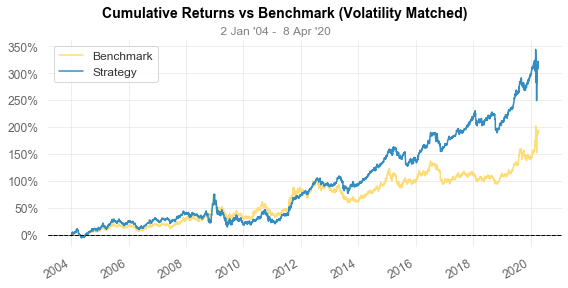

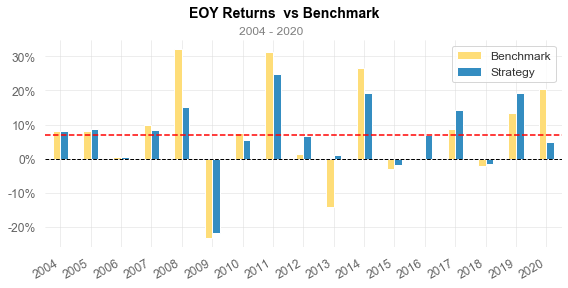

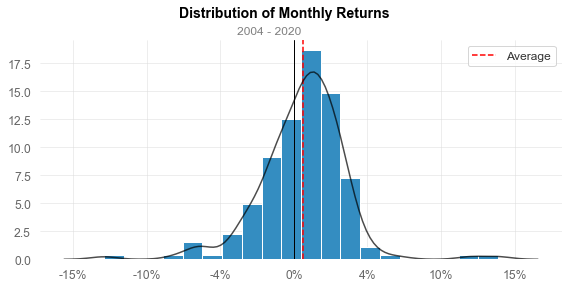

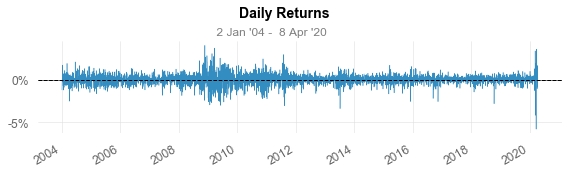

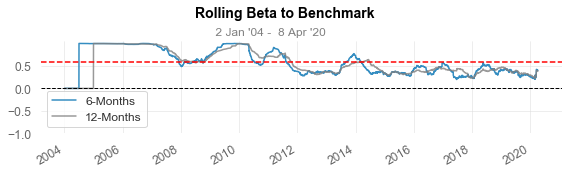

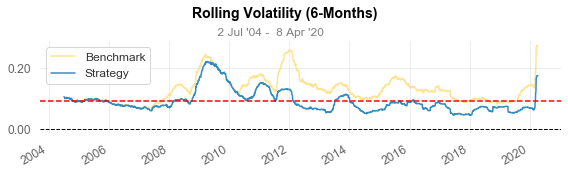

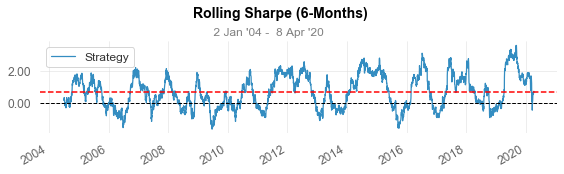

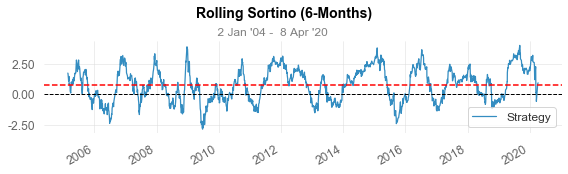

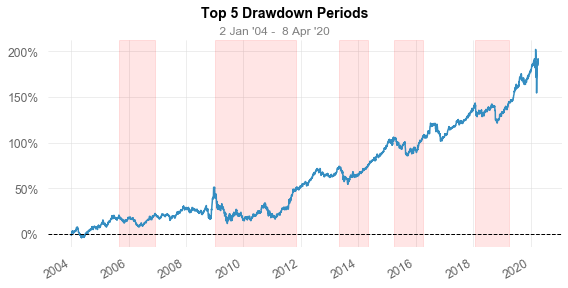

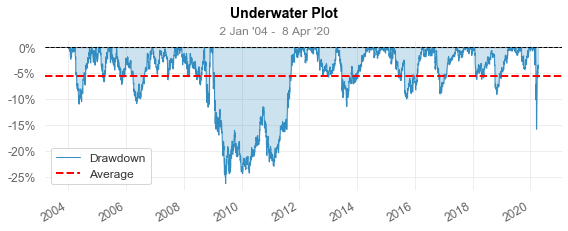

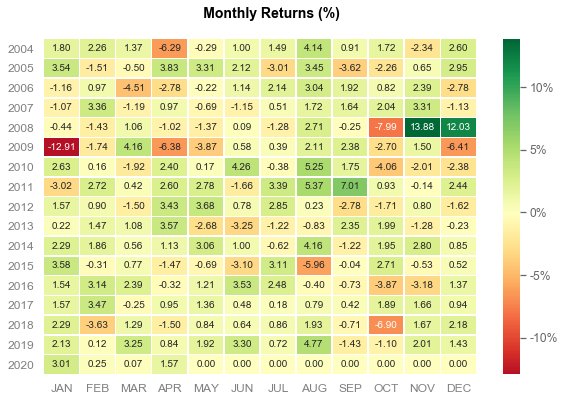

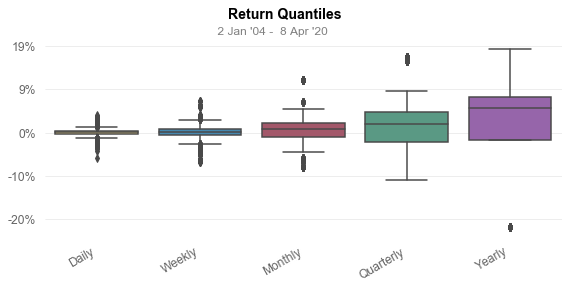

In [16]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['TLT_Return'])

<p>Overall it seems like our portfolio which targets a max sharpe actually has a lower sharpe then our minimum variance portfolio.</p>

<h2>Minimum Variance Testing Span of Exponential Covariance Matrix</h2>


In [ ]:
all_returns = pd.DataFrame()
for s in range(2,252):
    weights = pd.DataFrame()
    print(s)
    dates = daterange(date(2003, 12, 31), date(2020, 4, 8))
    for d in dates:
        if (d.day==1): print(f'{d.month}/{d.year}')  
        prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
        cov = exp_cov(prices,span=s,frequency=252)
        ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, 1)) 
        day_weights = ef.min_volatility()  
        weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
    weights = weights.add_suffix('_Weight')
    weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
    weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']
    port_returns = weights_total_returns['Portfolio_Return']
    port_returns.name = s
    all_returns = all_returns.append(port_returns)

In [ ]:
all_returns = all_returns.T

In [ ]:
statistics = pd.DataFrame()
for s in range(2,252):
    statistics = statistics.append((pd.DataFrame(qs.reports.metrics(mode='full', returns=all_returns.iloc[:,(s-2)],display=False)).rename({'Strategy':s},axis=1)).T)

In [ ]:
statistics.T

In [ ]:
statistics.to_csv('final_statistics.csv')

In [ ]:
statistics.columns

In [ ]:
statistics["Volatility (ann.) "].plot()

<p>It seems that after around Span = 11 it reaches a stable matrix where in the long run I acheive a stable volatility. Therefore our Span has to be bigger than 11.</p>

In [ ]:
statistics["Cumulative Return "].plot()

<p> It seems that aroun 60 to 90 span the portfolio has the highest cumulative return. Let's see what the Sharpe looks like</p>

In [ ]:
statistics['Sharpe'].plot()

In [ ]:
statistics['Sortino'].plot()

In [ ]:
statistics['Max Drawdown '].plot()

<p>It seems like the Max Drawdown gets stable after Span=50. Best Sharpe and Sortino are betweeen 57 and 97, so lets choose 77, and lets see what that looks like.<p>

<h1>Final Portfolio</h1>
<h2>Minimum Variance Portfolio with a Exp. Covariance Matrix Span = 77</h2>

In [126]:
dates = daterange(date(2005, 12, 31), date(2020, 4, 8))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, 1)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']

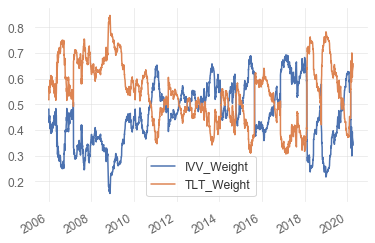

In [127]:
weights_total_returns[['IVV_Weight','TLT_Weight']].plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          209.7%      121.91%
CAGR%                      8.24%       5.74%
Sharpe                     0.99        0.38
Sortino                    1.39        0.52
Max Drawdown               -19.2%      -59.34%
Longest DD Days            630         2043
Volatility (ann.)          8.41%       19.99%
R^2                        0.16        0.16
Calmar                     0.43        0.1
Skew                       -0.62       -0.53
Kurtosis                   9.15        13.47

Expected Daily %           0.03%       0.02%
Expected Monthly %         0.66%       0.46%
Expected Yearly %          7.83%       5.46%
Kelly Criterion            6.86%       1.49%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.203125,-18.241092
2,2020-03-09,2020-03-18,2020-04-08,30,-15.776696,-14.193210
3,2007-12-04,2008-11-13,2008-12-04,366,-12.879178,-12.217151
4,2015-03-23,2015-08-25,2016-04-06,380,-8.565987,-8.222447
5,2018-01-29,2018-11-02,2019-03-20,415,-7.817105,-7.196627


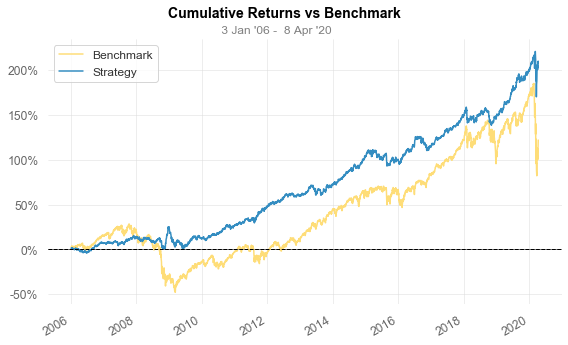

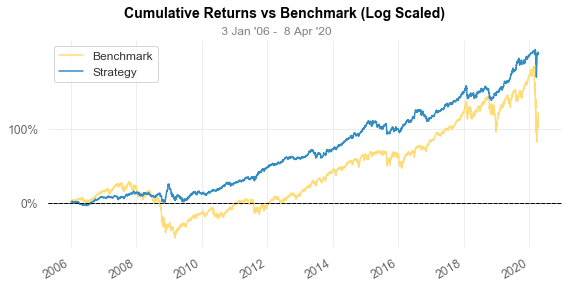

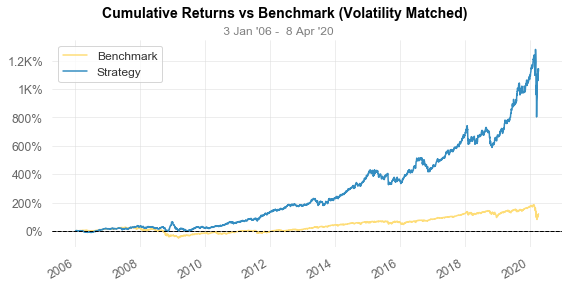

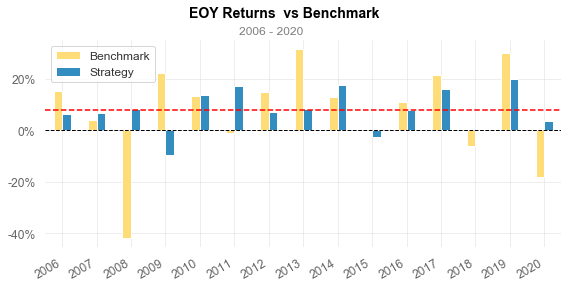

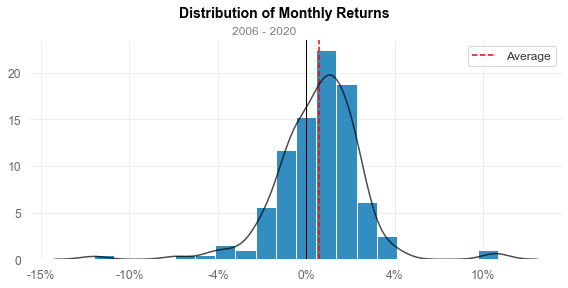

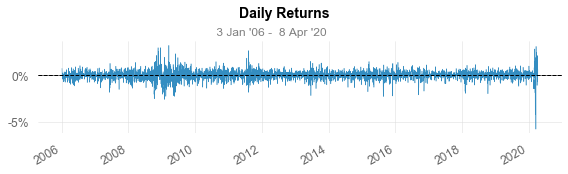

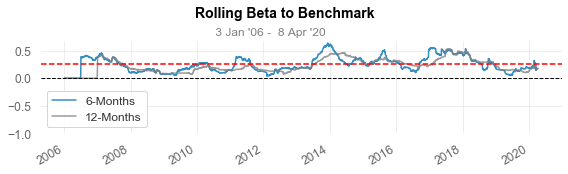

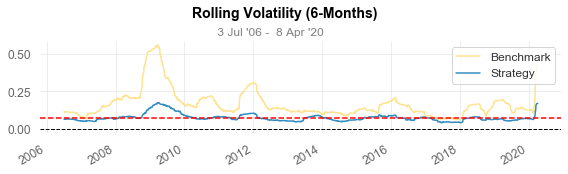

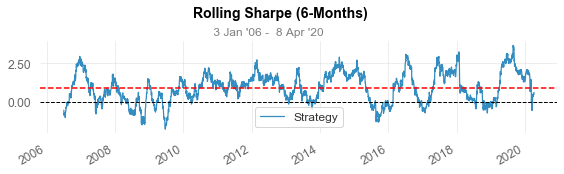

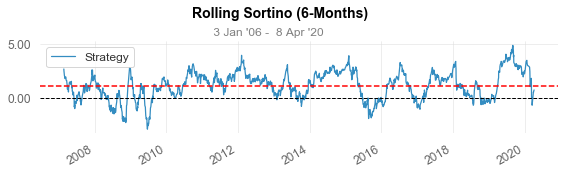

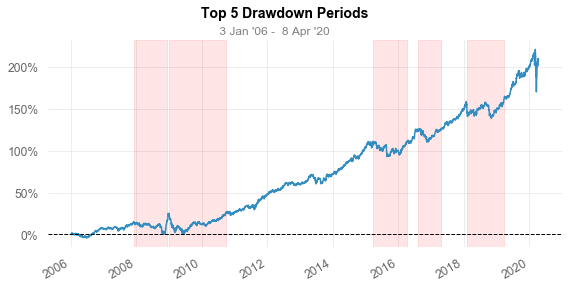

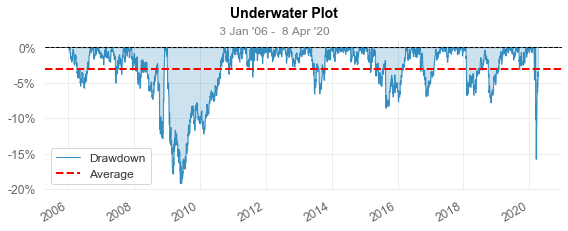

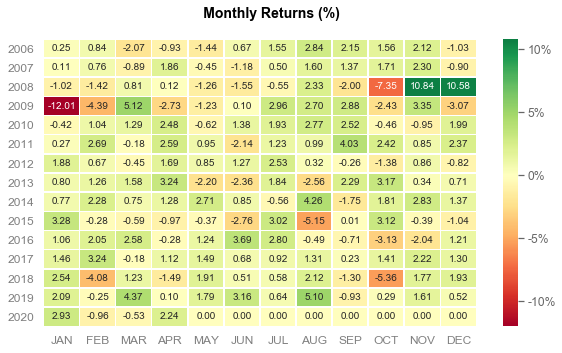

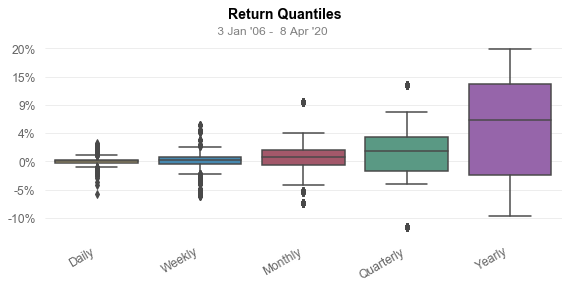

In [128]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['IVV_Return'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-04-08  2020-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          209.7%      146.21%
CAGR%                      8.24%       6.52%
Sharpe                     0.99        0.51
Sortino                    1.39        0.73
Max Drawdown               -19.2%      -27.37%
Longest DD Days            630         1116
Volatility (ann.)          8.41%       14.53%
R^2                        0.32        0.32
Calmar                     0.43        0.24
Skew                       -0.62       0.01
Kurtosis                   9.15        4.87

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.66%       0.53%
Expected Yearly %          7.83%       6.19%
Kelly Criterion            9.38%       -0.72%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.203125,-18.241092
2,2020-03-09,2020-03-18,2020-04-08,30,-15.776696,-14.193210
3,2007-12-04,2008-11-13,2008-12-04,366,-12.879178,-12.217151
4,2015-03-23,2015-08-25,2016-04-06,380,-8.565987,-8.222447
5,2018-01-29,2018-11-02,2019-03-20,415,-7.817105,-7.196627


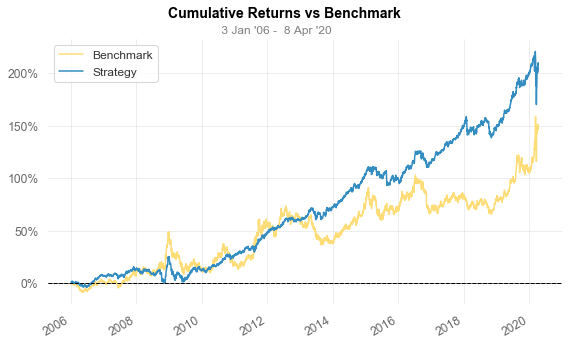

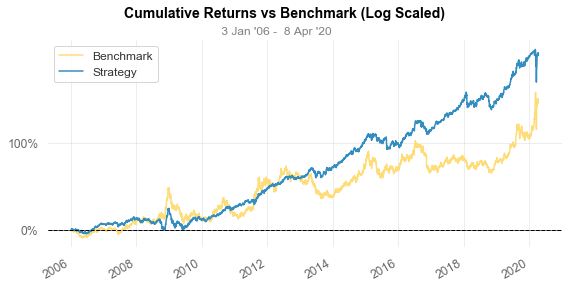

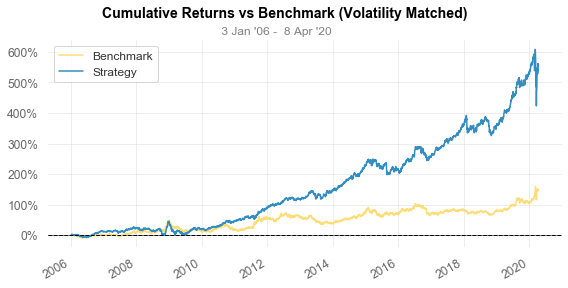

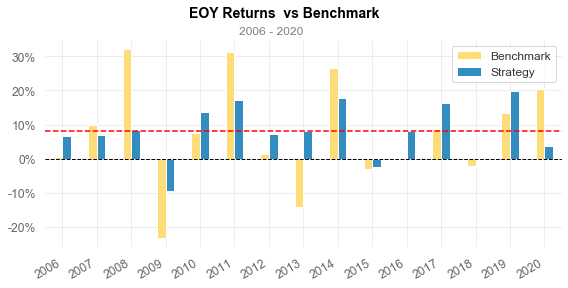

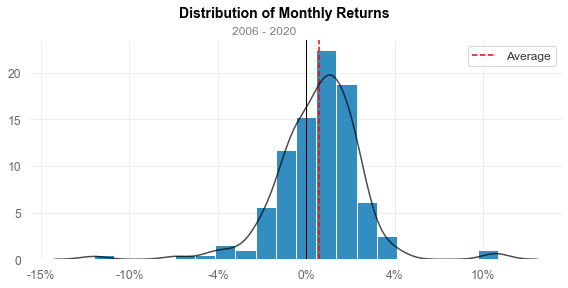

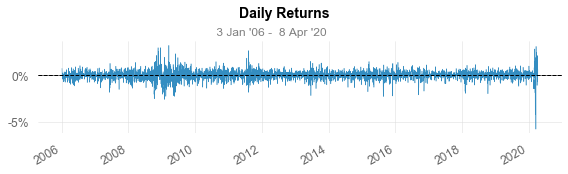

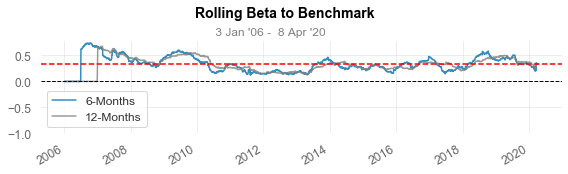

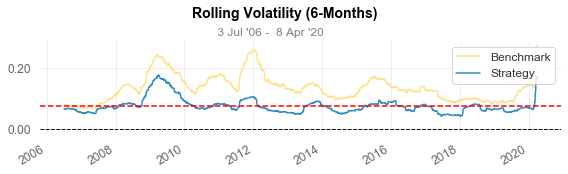

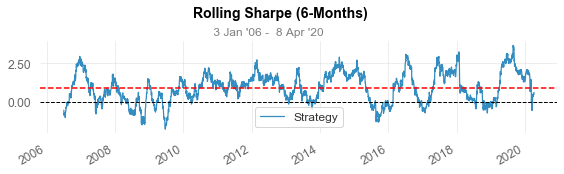

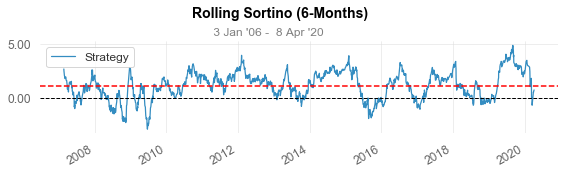

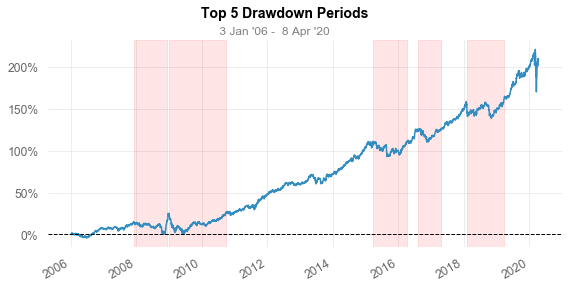

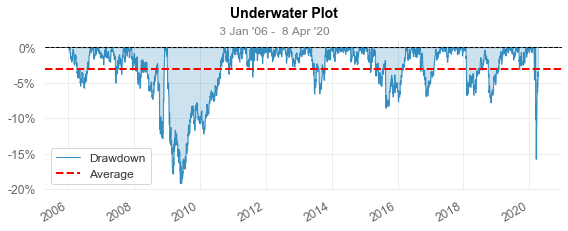

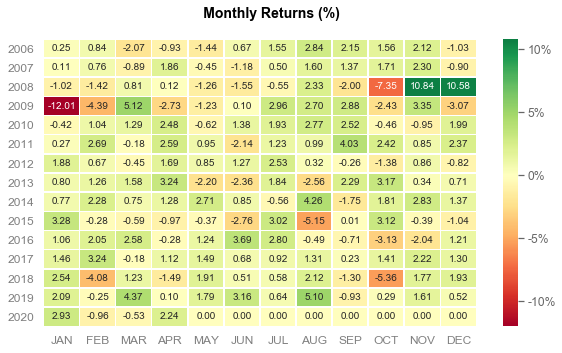

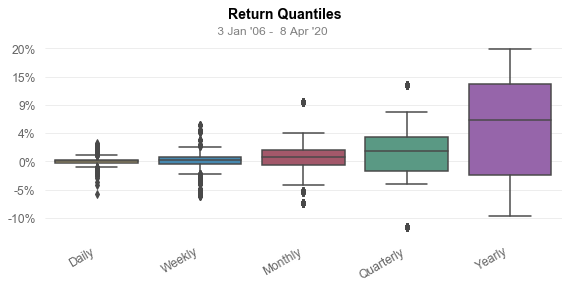

In [129]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['TLT_Return'])

<h2>Maximum Sharpe Portfolio using Historical Returns and Exponential Covariance MAtrix</h2>

In [32]:
[ivv_return[0],tlt_return[0]]

[0.0009571629599979321, 0.052029574826485056]

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
all_returns = pd.DataFrame()
for x in range(1,100):
    weights = pd.DataFrame()
    parameter = x/2 
    print(parameter)
    dates = daterange(date(2005, 12, 31), date(2020, 7, 8))
    for d in dates:
        #if ((d.day==1) & (d.month==1)): print(f'{d.year}')  
        
        prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
        cov = exp_cov(prices,span=77,frequency=252)
        
        total_returns = ivv_tlt_total_returns[ivv_tlt_total_returns.index<d]
        ivv_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['IVV_Return'].dropna()))
        tlt_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['TLT_Return'].dropna()))
    
        ef = EfficientFrontier(expected_returns=[ivv_return,tlt_return],cov_matrix=cov, weight_bounds=(0, 1))
        day_weights = ef.max_quadratic_utility(risk_aversion=parameter)
        
        weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
    weights = weights.add_suffix('_Weight')
    weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
    if 'IVV_Weight' not in weights_total_returns: weights_total_returns['IVV_Weight'] = 0
    if 'TLT_Weight' not in weights_total_returns: weights_total_returns['TLT_Weight'] = 0
    weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']
    port_returns = weights_total_returns['Portfolio_Return']
    port_returns.name = parameter
    weights_total_returns['Portfolio_Return']
    print('Return: ', end='')
    print((port_returns + 1).prod(axis=0))
    print('Volatility: ', end='')
    print(port_returns.std()*np.sqrt(252))
    all_returns = all_returns.append(port_returns)

0.5
Return: 2.2910822587807425
Volatility: 0.13880106968111514
1.0
Return: 2.247661556081619
Volatility: 0.1320130018411675
1.5
Return: 2.3156045720065954
Volatility: 0.1240280510775508
2.0
Return: 2.391036808286257
Volatility: 0.11489216006594716
2.5
Return: 2.489881678789059
Volatility: 0.1069246155404735
3.0
Return: 2.5558179375683245
Volatility: 0.10123926284248405
3.5
Return: 2.616954748529598
Volatility: 0.09731508232416464
4.0
Return: 2.664040912952079
Volatility: 0.09467039085041214
4.5
Return: 2.7017086875207865
Volatility: 0.09280116617033488
5.0
Return: 2.732881219896573
Volatility: 0.09143170143991043
5.5
Return: 2.762637578374699
Volatility: 0.09039059138071961
6.0
Return: 2.7900446172427973
Volatility: 0.08957767605105438
6.5
Return: 2.814602972682627
Volatility: 0.08893514662931488
7.0
Return: 2.835693142034564
Volatility: 0.0884210948475065
7.5
Return: 2.8537992912450876
Volatility: 0.0880036417417804
8.0
Return: 2.868981189982084
Volatility: 0.08765603039348589
8.5
Ret

In [97]:
all_returns = all_returns.T

In [98]:
all_returns

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,45.0,45.5,46.0,46.5,47.0,47.5,48.0,48.5,49.0,49.5
2006-01-03,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,-0.001306,...,0.005745,0.005765,0.005785,0.005805,0.005824,0.005843,0.005861,0.005879,0.005897,0.005914
2006-01-04,0.002394,0.002394,0.002394,0.002394,0.002394,0.002394,0.002394,0.002394,0.002394,0.002394,...,0.003461,0.003464,0.003467,0.003470,0.003473,0.003476,0.003478,0.003481,0.003484,0.003486
2006-01-05,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,-0.001196,...,-0.000501,-0.000499,-0.000497,-0.000496,-0.000494,-0.000492,-0.000490,-0.000489,-0.000487,-0.000485
2006-01-06,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,-0.001852,...,0.001654,0.001664,0.001674,0.001684,0.001693,0.001702,0.001711,0.001720,0.001729,0.001737
2006-01-09,0.000654,0.000654,0.000654,0.000654,0.000654,0.000654,0.000654,0.000654,0.000654,0.000654,...,0.001304,0.001306,0.001307,0.001309,0.001311,0.001313,0.001314,0.001316,0.001317,0.001319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,-0.000801,0.000234,0.000579,0.000752,0.000855,0.000925,0.000974,0.001011,0.001040,0.001063,...,0.001247,0.001247,0.001247,0.001247,0.001248,0.001248,0.001248,0.001248,0.001249,0.001249
2020-07-01,0.000068,0.000554,0.000716,0.000798,0.000846,0.000879,0.000902,0.000919,0.000933,0.000944,...,0.001030,0.001030,0.001030,0.001030,0.001031,0.001031,0.001031,0.001031,0.001031,0.001031
2020-07-02,0.002022,0.002246,0.002321,0.002358,0.002381,0.002395,0.002406,0.002414,0.002420,0.002425,...,0.002465,0.002465,0.002465,0.002465,0.002465,0.002465,0.002465,0.002465,0.002466,0.002466
2020-07-06,0.000398,0.001432,0.001777,0.001949,0.002053,0.002121,0.002171,0.002208,0.002236,0.002259,...,0.002443,0.002443,0.002444,0.002444,0.002444,0.002444,0.002445,0.002445,0.002445,0.002445


In [102]:
statistics = pd.DataFrame()
for x in range(1,100):
    statistics = statistics.append((pd.DataFrame(qs.reports.metrics(mode='full', returns=all_returns.iloc[:,(x-1)],display=False)).rename({'Strategy':(x/2)},axis=1)).T)

In [103]:
statistics

,Start Period,End Period,Risk-Free Rate,Time in Market,Cumulative Return,CAGR%,Sharpe,Sortino,Max Drawdown,Longest DD Days,...,Avg. Drawdown,Avg. Drawdown Days,Recovery Factor,Ulcer Index,Avg. Up Month,Avg. Down Month,Win Days %,Win Month %,Win Quarter %,Win Year %
0.5,2006-01-03,2020-07-07,0,1,1.29,0.06,0.48,0.68,-0.27,1129,...,-0.04,97,4.72,1.03,0.03,-0.02,0.53,0.53,0.59,0.73
1.0,2006-01-03,2020-07-07,0,1,1.25,0.06,0.49,0.69,-0.27,1123,...,-0.04,88,4.56,1.03,0.03,-0.02,0.54,0.55,0.63,0.73
1.5,2006-01-03,2020-07-07,0,1,1.32,0.06,0.53,0.75,-0.27,1061,...,-0.03,79,4.81,1.02,0.03,-0.02,0.54,0.58,0.63,0.73
2.0,2006-01-03,2020-07-07,0,1,1.39,0.06,0.58,0.82,-0.26,992,...,-0.03,70,5.43,1.02,0.03,-0.02,0.54,0.59,0.64,0.73
2.5,2006-01-03,2020-07-07,0,1,1.49,0.06,0.64,0.9,-0.24,974,...,-0.02,58,6.12,1.02,0.02,-0.02,0.54,0.58,0.64,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47.5,2006-01-03,2020-07-07,0,1,2.18,0.08,0.99,1.4,-0.19,635,...,-0.01,25,11.2,1.02,0.02,-0.02,0.55,0.66,0.73,0.8
48.0,2006-01-03,2020-07-07,0,1,2.18,0.08,0.99,1.4,-0.19,635,...,-0.01,25,11.21,1.02,0.02,-0.02,0.55,0.66,0.73,0.8
48.5,2006-01-03,2020-07-07,0,1,2.18,0.08,0.99,1.4,-0.19,635,...,-0.01,25,11.21,1.02,0.02,-0.02,0.55,0.66,0.73,0.8
49.0,2006-01-03,2020-07-07,0,1,2.18,0.08,0.99,1.4,-0.19,635,...,-0.01,25,11.22,1.02,0.02,-0.02,0.55,0.66,0.73,0.8


In [109]:
statistics.columns

Index(['Start Period', 'End Period', 'Risk-Free Rate ', 'Time in Market ',
       'Cumulative Return ', 'CAGR%', 'Sharpe', 'Sortino', 'Max Drawdown ',
       'Longest DD Days', 'Volatility (ann.) ', 'Calmar', 'Skew', 'Kurtosis',
       'Expected Daily %', 'Expected Monthly %', 'Expected Yearly %',
       'Kelly Criterion ', 'Risk of Ruin ', 'Daily Value-at-Risk ',
       'Expected Shortfall (cVaR) ', 'Payoff Ratio', 'Profit Factor',
       'Common Sense Ratio', 'CPC Index', 'Tail Ratio', 'Outlier Win Ratio',
       'Outlier Loss Ratio', 'MTD ', '3M ', '6M ', 'YTD ', '1Y ', '3Y (ann.) ',
       '5Y (ann.) ', '10Y (ann.) ', 'All-time (ann.) ', 'Best Day ',
       'Worst Day ', 'Best Month ', 'Worst Month ', 'Best Year ',
       'Worst Year ', 'Avg. Drawdown ', 'Avg. Drawdown Days',
       'Recovery Factor', 'Ulcer Index', 'Avg. Up Month ', 'Avg. Down Month ',
       'Win Days %', 'Win Month %', 'Win Quarter %', 'Win Year %'],
      dtype='object')

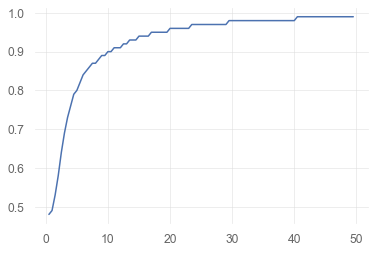

In [110]:
statistics['Sharpe'].plot()

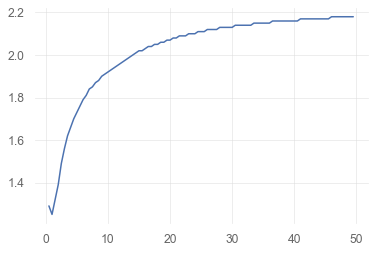

In [111]:
statistics['Cumulative Return '].plot()

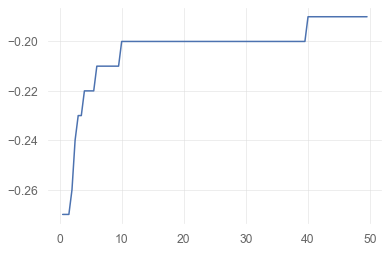

In [116]:
statistics['Max Drawdown '].plot()

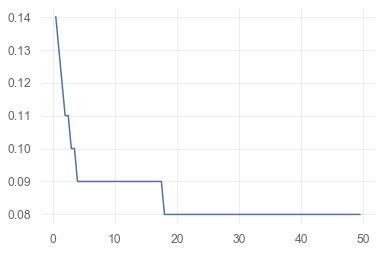

In [117]:
statistics['Volatility (ann.) '].plot()

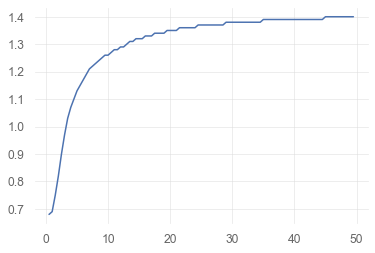

In [118]:
statistics['Sortino'].plot()

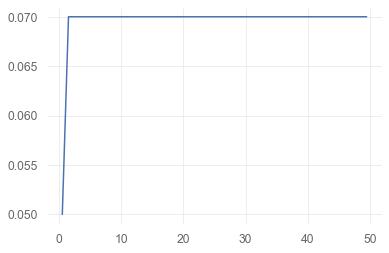

In [120]:
statistics['3M '].plot()

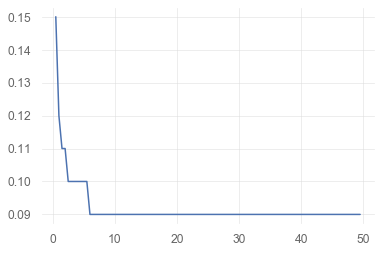

In [121]:
statistics['YTD '].plot()

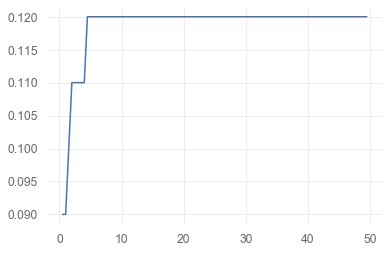

In [122]:
statistics['3Y (ann.) '].plot()

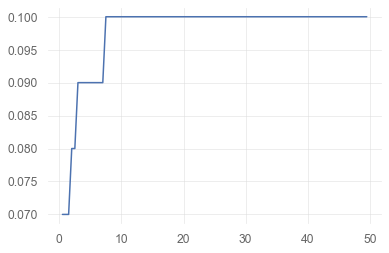

In [123]:
statistics['5Y (ann.) '].plot()

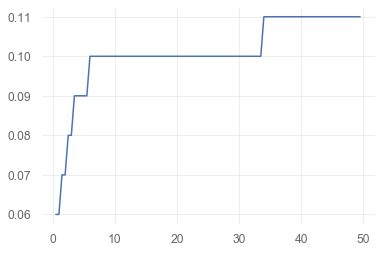

In [124]:
statistics['10Y (ann.) '].plot()

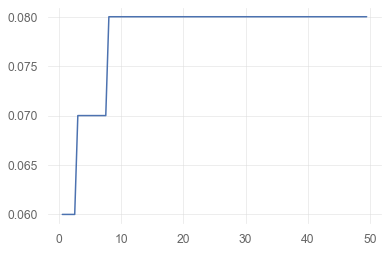

In [125]:
statistics['All-time (ann.) '].plot()

In [131]:
all_returns = pd.DataFrame()
for x in range(1,100):
    weights = pd.DataFrame()
    parameter = x/2 
    print(parameter)
    dates = daterange(date(2005, 12, 31), date(2020, 7, 8))
    for d in dates:
        #if ((d.day==1) & (d.month==1)): print(f'{d.year}')  
        
        prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
        cov = exp_cov(prices,span=77,frequency=252)
        cov.loc['Cash'] = cov['Cash'] = 0.0
        
        total_returns = ivv_tlt_total_returns[ivv_tlt_total_returns.index<d]
        ivv_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['IVV_Return'].dropna()))
        tlt_return = expected_returns.mean_historical_return(prices_from_returns(total_returns['TLT_Return'].dropna()))
    
        ef = EfficientFrontier(expected_returns=[ivv_return,tlt_return,0],cov_matrix=cov, weight_bounds=(0, 1))
        day_weights = ef.max_quadratic_utility(risk_aversion=parameter)
        
        weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
    weights = weights.add_suffix('_Weight')
    weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
    if 'IVV_Weight' not in weights_total_returns: weights_total_returns['IVV_Weight'] = 0
    if 'TLT_Weight' not in weights_total_returns: weights_total_returns['TLT_Weight'] = 0
    weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']
    port_returns = weights_total_returns['Portfolio_Return']
    port_returns.name = parameter
    weights_total_returns['Portfolio_Return']
    print('Return: ', end='')
    print((port_returns + 1).prod(axis=0))
    print('Volatility: ', end='')
    print(port_returns.std()*np.sqrt(252))
    all_returns = all_returns.append(port_returns)

0.5
Return: 2.291095544629799
Volatility: 0.13880095289875483
1.0
Return: 2.247670197188109
Volatility: 0.13201297954977992
1.5
Return: 2.241780715063727
Volatility: 0.12352976928093654
2.0
Return: 2.218281987611372
Volatility: 0.11293137050908846
2.5
Return: 2.2732637090651457
Volatility: 0.10324095309470734
3.0
Return: 2.3265401473413734
Volatility: 0.09566818470426273
3.5
Return: 2.34361987782988
Volatility: 0.08990583360099862
4.0
Return: 2.3368000009948107
Volatility: 0.08564334500096753
4.5
Return: 2.3238885617995355
Volatility: 0.08243551075988616
5.0
Return: 2.3186514948180057
Volatility: 0.07990836255471699
5.5
Return: 2.309648631426485
Volatility: 0.07787413574147617
6.0
Return: 2.3046223027361674
Volatility: 0.07595755656529785
6.5
Return: 2.2985669744389043
Volatility: 0.07418264601128124
7.0
Return: 2.2865269960982433
Volatility: 0.0725826928162753
7.5
Return: 2.2698403133725655
Volatility: 0.07108367318671234
8.0
Return: 2.253134864617157
Volatility: 0.06963478235099388
8

In [132]:
all_returns = all_returns.T

In [133]:
statistics = pd.DataFrame()
for x in range(1,100):
    statistics = statistics.append((pd.DataFrame(qs.reports.metrics(mode='full', returns=all_returns.iloc[:,(x-1)],display=False)).rename({'Strategy':(x/2)},axis=1)).T)

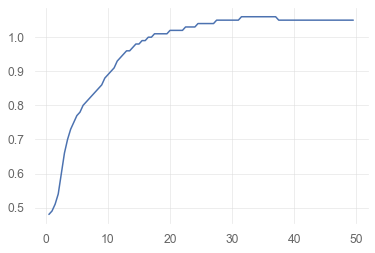

In [134]:
statistics['Sharpe'].plot()